## Superradiant light emission

Notebook author: Nathan Shammah (nathan.shammah at gmail.com)

We consider a system of $N$ two-level systems (TLSs) with identical frequency $\omega_{0}$, which can emit collectively at a rate $\gamma_\text{CE}$ [1], and suffer from dephasing and local losses at rates $\gamma_\text{D}$ and $\gamma_\text{E}$, respectively. The dynamics can be written as
\begin{eqnarray}
\dot{\rho} &=&-i\lbrack \omega_{0}J_z,\rho \rbrack
+\frac{\gamma_\text {CE}}{2}\mathcal{L}_{J_{-}}[\rho]
+\sum_{n=1}^{N}\frac{\gamma_\text{D}}{2}\mathcal{L}_{J_{z,n}}[\rho]
+\frac{\gamma_\text{E}}{2}\mathcal{L}_{J_{-,n}}[\rho]
\end{eqnarray}

When $\gamma_\text{E}=\gamma_\text{D}=0$ this dynamics is the classical superradiant master equation.
In this limit, a system initially prepared in the fully-excited state undergoes superradiant light emission whose peak intensity scales proportionally to $N^2$.

This dynamics has been studied in Refs. [2-4] and implemented in various quantum optical platforms, including in the solid state [5-10]. 

Below, using PIQS [4] and QuTiP [11], we investigate the time evolution of the collective dynamics for an ensemble initialized in different initial quantum states.

In [1]:
from time import clock
import matplotlib.pyplot as plt
import scipy

from qutip import *
from piqs import *

from scipy.sparse import load_npz, save_npz

In [2]:
N = 20
ntls = N
nds = num_dicke_states(N)
print("The number of Dicke states is", nds)
[jx, jy, jz] = jspin(N)
jp = jspin(N, "+")
jm = jspin(N, "-")
system = Dicke(N = N)

The number of Dicke states is 121


In [3]:
a = 1/np.sqrt(2)
b = 1/np.sqrt(2)
css_symmetric = css(N, a, b)
css_antisymmetric = css(N, a,-b)
excited_ = dicke(N, N/2,N/2)
superradiant = dicke(N,N/2,0)
subradiant = dicke(N,j_min(N),-j_min(N))
ground_ = dicke(N,N/2,-N/2)
ghz_ = ghz(N)

In [4]:
# here we set the initial coefficients
gE = 0 # local emission
gD = 1 # local dephasing
gP = 0 # local pumping
gCE = 1 # collective emission
gCD = 0 # collective dephasing
gCP = 0 # collective pumping
w0 = 1  # bare frequency
wi = 0  # coherent drive frequency

# spin hamiltonian
h0 = w0 * jz
hint = wi * jx
h = h0 #+ hint

#set initial conditions for spins by initializing the system and building the Liouvillian matrix
system = Dicke(hamiltonian = h, 
               N = N, 
               emission = gE, 
               pumping = gP, 
               dephasing = gD, 
               collective_emission = gCE, 
               collective_pumping = gCP, 
               collective_dephasing = gCD)
clock_t0 = clock()
lind = system.lindbladian()
liouv = system.liouvillian()
clock_tf = clock()
dt_clock = clock_tf - clock_t0
print("Time (in seconds) to generate the Liouvillian for N = 20 TLSs:", dt_clock)

Time (in seconds) to generate the Liouvillian for N = 20 TLSs: 0.055079999999999796


In [33]:
file_save = True
file_load = False
if file_save is True:
#Save to file (sparse)
    saveto_file_name = str("srle_liouvillian_data_N={}_gE{}_gD{}.npz".format(N,gE,gD))
    save_npz('{}'.format(saveto_file_name), liouv.data)
    print("Liouvillian data saved from {} in {}".format(str("liouv"),saveto_file_name))    
if file_load is True:
#Load from file (sparse)
    loadfrom_file_name = str("srle_liouvillian_data_N={}_gE{}_gD{}.npz".format(N,gE,gD))
    liouv_data = load_npz('{}'.format(loadfrom_file_name))
    print("Liouvillian data loaded from {} into {}".format(loadfrom_file_name, str("liouv_data")))

Liouvillian data saved from liouv in srle_liouvillian_data_N=20_gE0_gD1.npz


In [34]:
## Solution of the dynamics for different initial conditions

# parameters for the time integration of the dynamics
nt = 1001
td0 = np.log(N)/(N*gCE) # delay time is used as a reference
tmax = 10 * td0
t = np.linspace(0, tmax, nt)

# initial states 
rho01 = excited_
rho02 = superradiant
rho03 = css_symmetric
rho04 = css_antisymmetric
rho05 = subradiant
rho06 = ghz_

#Excited
clock_t0 = clock()
result1 = mesolve(liouv, rho01, t, [], e_ops = [jz, jp*jm, jz**2], 
                  options = Options(store_states=True))
rhot1 = result1.states
jz_t1 = result1.expect[0]
jpjm_t1 = result1.expect[1]
jz2_t1 = result1.expect[2]
clock_tf = clock()
dt_clock = clock_tf - clock_t0
print("Elapsed time (in seconds) for this run: ", dt_clock)

#Superradiant
clock_t0 = clock()
result2 = mesolve(liouv, rho02, t, [], e_ops = [jz, jp*jm, jz**2], 
                  options = Options(store_states=True))
rhot2 = result2.states
jz_t2 = result2.expect[0]
jpjm_t2 = result2.expect[1]
jz2_t2 = result2.expect[2]
clock_tf = clock()
dt_clock = clock_tf - clock_t0
print("Elapsed time (in seconds) for this run: ", dt_clock)

#CSS Symmetric
clock_t0 = clock()
result3 = mesolve(liouv, rho03, t, [], e_ops = [jz, jp*jm, jz**2], 
                  options = Options(store_states=True))
rhot3 = result3.states
jz_t3 = result3.expect[0]
jpjm_t3 = result3.expect[1]
jz2_t3 = result3.expect[2]
clock_tf = clock()
dt_clock = clock_tf - clock_t0
print("Elapsed time (in seconds) for this run: ", dt_clock)

#CSS Antisymmetric
clock_t0 = clock()
result4 = mesolve(liouv, rho04, t, [], e_ops = [jz, jp*jm, jz**2], 
                  options = Options(store_states=True))
rhot4 = result4.states
jz_t4 = result4.expect[0]
jpjm_t4 = result4.expect[1]
jz2_t4 = result4.expect[2]
clock_tf = clock()
dt_clock = clock_tf - clock_t0
print("Elapsed time (in seconds) for this run: ", dt_clock)

#Subradiant
clock_t0 = clock()
result5 = mesolve(liouv, rho05, t, [], e_ops = [jz, jp*jm, jz**2], 
                  options = Options(store_states=True))
rhot5 = result5.states
jz_t5 = result5.expect[0]
jpjm_t5 = result5.expect[1]
jz2_t5 = result5.expect[2]
clock_tf = clock()
dt_clock = clock_tf - clock_t0
print("Elapsed time (in seconds) for this run: ", dt_clock)

#GHZ
clock_t0 = clock()
result6 = mesolve(liouv, rho06, t, [], e_ops = [jz, jp*jm, jz**2], 
                  options = Options(store_states=True))
rhot6 = result6.states
jz_t6 = result6.expect[0]
jpjm_t6 = result6.expect[1]
jz2_t6 = result6.expect[2]
clock_tf = clock()
dt_clock = clock_tf - clock_t0
print("Elapsed time (in seconds) for this run: ", dt_clock)

Elapsed time (in seconds) for this run:  0.9871820000000007
Elapsed time (in seconds) for this run:  2.335818999999997
Elapsed time (in seconds) for this run:  1.1605939999999997
Elapsed time (in seconds) for this run:  1.1580779999999997
Elapsed time (in seconds) for this run:  0.7962980000000002
Elapsed time (in seconds) for this run:  0.9535160000000005


#### Visualization

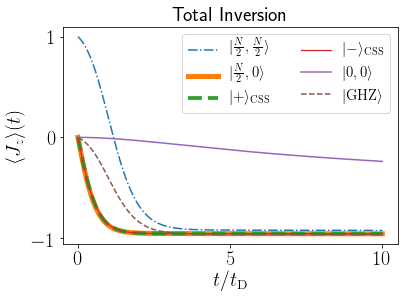

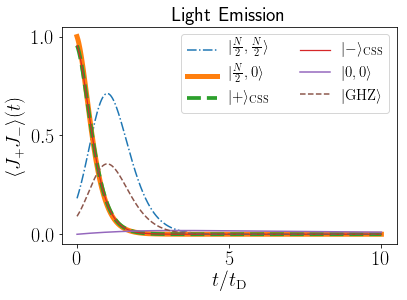

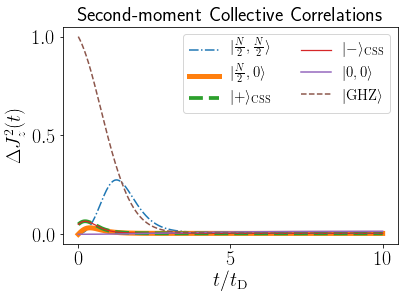

In [36]:
jmax = (0.5 * N)
j2max = (0.5 * N + 1) * (0.5 * N)

label_size = 20
label_size2 = 20
label_size3 = 20
label_size4 = 15
l0=2.5
lw1 = 2
lw2 = 1.5
lw3 = 0.5
plt.rc('text', usetex = True)


fig1 = plt.figure()
plt.plot(t/td0, jz_t1/jmax, '-.', label = r"$|\frac{N}{2},\frac{N}{2}\rangle$")
plt.plot(t/td0, jz_t2/jmax, '-', linewidth=lw1*l0, label = r"$|\frac{N}{2},0\rangle$")
plt.plot(t/td0, jz_t3/jmax, '--', linewidth=lw2*l0, label = r"$|+\rangle_\mathrm{CSS}$")
plt.plot(t/td0, jz_t4/jmax, '-',linewidth=lw3*l0, label = r"$|-\rangle_\mathrm{CSS}$")
plt.plot(t/td0,jz_t5/jmax, '-', label = r"$|0,0\rangle$")
plt.plot(t/td0,jz_t6/jmax, '--', label = r"$|\mathrm{GHZ}\rangle$")
#plt.ylim([-1,1])
plt.xlabel(r'$t/t_\mathrm{D}$', fontsize = label_size3)
plt.ylabel(r'$\langle J_{z} \rangle(t)$', fontsize = label_size3)
plt.xticks([0,(tmax/2)/td0,tmax/td0])
plt.yticks([-1,0,1])
plt.legend(fontsize = label_size4, ncol = 2)
fname = 'srle_jzt_N{}_gE{}_gD{}.pdf'.format(N,gE,gD)
if file_save is True:
    plt.savefig(fname, bbox_inches='tight')    
plt.title(r'Total Inversion', fontsize = label_size3)    
plt.show()
plt.close()

fig2 = plt.figure()
plt.plot(t/td0, jpjm_t1/j2max, '-.', label = r"$|\frac{N}{2},\frac{N}{2}\rangle$")
plt.plot(t/td0, jpjm_t2/j2max, '-', linewidth=lw1*l0, label = r"$|\frac{N}{2},0\rangle$")
plt.plot(t/td0, jpjm_t3/j2max, '--', linewidth=lw2*l0,label = r"$|+\rangle_\mathrm{CSS}$")
plt.plot(t/td0, jpjm_t4/j2max, '-', linewidth=lw3*l0,label = r"$|-\rangle_\mathrm{CSS}$")
plt.plot(t/td0,jpjm_t5/j2max, '-', label = r"$|0,0\rangle$")
plt.plot(t/td0,jpjm_t6/j2max, '--', label = r"$|\mathrm{GHZ}\rangle$")
#plt.ylim([0,1])
plt.xticks([0,(tmax/2)/td0,tmax/td0])
plt.yticks([0,0.5,1])
plt.xlabel(r'$t/t_\mathrm{D}$', fontsize = label_size3)
plt.ylabel(r'$\langle J_{+}J_{-}\rangle(t)$', fontsize = label_size3)
plt.legend(fontsize = label_size4, ncol = 2)
fname = 'srle_jpjmt_N{}_gE{}_gD{}.pdf'.format(N,gE,gD)
if file_save is True:
    plt.savefig(fname, bbox_inches='tight')
plt.title(r'Light Emission', fontsize = label_size3)    
plt.show()
plt.close()

fig3 = plt.figure()
djz1 = (jz2_t1- jz_t1**2)/jmax**2
djz2 = (jz2_t2- jz_t2**2)/jmax**2
djz3 = (jz2_t3- jz_t3**2)/jmax**2
djz4 = (jz2_t4- jz_t4**2)/jmax**2
djz5 = (jz2_t5- jz_t5**2)/jmax**2
djz6 = (jz2_t6- jz_t6**2)/jmax**2

plt.plot(t/td0, djz1, '-.', label = r"$|\frac{N}{2},\frac{N}{2}\rangle$")
plt.plot(t/td0, djz2, '-', linewidth=lw1*l0, label = r"$|\frac{N}{2},0\rangle$")
plt.plot(t/td0, djz3, '--', linewidth=lw2*l0, label = r"$|+\rangle_\mathrm{CSS}$")
plt.plot(t/td0, djz4, '-', linewidth=lw3*l0, label = r"$|-\rangle_\mathrm{CSS}$")
plt.plot(t/td0, djz5, '-', label = r"$|0,0\rangle$")
plt.plot(t/td0, djz6, '--', label = r"$|\mathrm{GHZ}\rangle$")
#plt.ylim([-1,1])
plt.xticks([0,(tmax/2)/td0,tmax/td0])
plt.yticks([0,0.5,1])
plt.xlabel(r'$t/t_\mathrm{D}$', fontsize = label_size3)
plt.ylabel(r'$\Delta J_{z}^2(t)$', fontsize = label_size3)
plt.rc('xtick', labelsize=label_size) 
plt.rc('ytick', labelsize=label_size)
plt.legend(fontsize = label_size4, ncol = 2)
fname = 'srle_jz2t_N{}_gE{}_gD{}.pdf'.format(N,gE,gD)
if file_save is True:
    plt.savefig(fname, bbox_inches='tight')
plt.title(r'Second-moment Collective Correlations', fontsize = label_size3)
plt.show()
plt.close()

We have found very different time evolutions for different quantum states that experience the same dynamics, leading to superradiant light emission, subradiance, delayed superradiant decay (superfluorescence), and macroscopic quantum correlations. 


#### References

[1] R. H. Dicke, Coherence in spontaneous radiation processes, *Phys. Rev.* **93**, 99 (1954) 

[2] R. Bonifacio, P. Schwendimann, and F. Haake, Quantum statistical theory of superradiance. I, *Phys. Rev. A* **4**, 302 (1971); ibid. **4**, 854 (1971); 
R. Bonifacio and L. A. Lugiato, Cooperative radiation processes in two-level systems: Superfluorescence, *Phys. Rev. A* **11**, 1507 (1975)

[3]  N. Shammah, N. Lambert, F. Nori, and S. De Liberato, Superradiance with local phase-breaking effects, *Phys. Rev. A* **96**, 023863 (2017)

[4] N. Shammah, S. Ahmed, N. Lambert, S. De Liberato, and F. Nori, Open quantum systems with local and collective incoherent processes: Efficient numerical simulation using permutational invariance, **Phys. Rev. A 98, 063815 (2018)**
https://arxiv.org/abs/1805.05129 and https://github.com/nathanshammah/piqs/

[5] G. T. Noe II, J.-H. Kim, J. Lee, Y. Wang, A. K. Wojcik, S. A. McGill, D. H. Reitze, A. A. Belyanin, and J. Kono, Giant superfluorescent bursts from a semiconductor magneto-plasma, *Nature Phys.* **8**, 219 (2012)

[6] T. Bienaimé, N. Piovella, and R. Kaiser, Controlled Dicke subradiance from a large cloud of two-level systems, *Phys. Rev. Lett.* **108**, 123602 (2012)

[7] A. F. van Loo, A. Fedorov, K. Lalumière, B. C. Sanders, A. Blais, and A. Wallraff, Photon-mediated interactions between distant artificial atoms, *Science* **342**, 1494 (2013)

[8] A. Goban, C.-L. Hung, J. D. Hood, S.-P. Yu, J. A. Muniz, O. Painter, and H. J. Kimble, Superradiance for atoms trapped along a photonic crystal waveguide, *Phys. Rev. Lett.* **115**, 063601 (2015)

[9]  C. Bradac, M. T. Johnsson, M. v. Breugel, B. Q. Baragiola, R. Martin, M. L. Juan, G. K. Brennen, and T. Volz, Room-temperature spontaneous superradiance from single diamond nanocrystals, *Nature Commun.* **8**,
1205 (2017)

[10]  A. Angerer, K. Streltsov, T. Astner, S. Putz, H. Sumiya, S. Onoda, W. J. Munro, K. Nemoto, J. Schmiedmayer, and J. Majer, Superradiant hybrid quantum devices, arXiv:1802.07100 (2018)

[11] J.R. Johansson, P.D. Nation, and F. Nori, *Comp. Phys. Comm.* **183**, 1760 (2012) http://qutip.org

In [8]:
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) 2011 and later.
A. J. Pitchford, P. D. Nation, R. J. Johansson, A. Grimsmo, and C. Granade

QuTiP Version:      4.4.0.dev0+d91a4c93
Numpy Version:      1.13.3
Scipy Version:      1.0.0
Cython Version:     0.27.3
Matplotlib Version: 2.1.1
Python Version:     3.6.3
Number of CPUs:     2
BLAS Info:          INTEL MKL
OPENMP Installed:   False
INTEL MKL Ext:      True
Platform Info:      Darwin (x86_64)
Installation path:  /Users/nathanshammah/Dropbox/GitHub/qutip/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`
